<a href="https://colab.research.google.com/github/ArunK-ML/Project---TripFare-Predicting-Urban-Taxi-Fare-with-Machine-Learning/blob/main/Taxi_trip_Finalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Basic libraries
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/taxi_fare_Download.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1.0,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1.0,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1.0,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1.0,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1.0,98.0,0.0,0.0,0.00,15.50,0.3,113.80


In [6]:
print(df["tpep_pickup_datetime"].max())
print(df["tpep_pickup_datetime"].min())

2016-03-10 14:27:09
2016-03-01 00:00:00


In [7]:

def haversine_distance(lat1, lon1, lat2, lon2, unit="km"):
    R_km = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance_km = R_km * c

    if unit.lower() == "miles":
        return distance_km * 0.621371
    return distance_km

# For miles
df["trip_distance_miles"] = haversine_distance(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"],
    unit="miles"
)


In [8]:
df["tpep_pickup_datetime"]=pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"]=pd.to_datetime(df["tpep_dropoff_datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143680 entries, 0 to 143679
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               143680 non-null  int64         
 1   tpep_pickup_datetime   143680 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  143680 non-null  datetime64[ns]
 3   passenger_count        143680 non-null  int64         
 4   pickup_longitude       143680 non-null  float64       
 5   pickup_latitude        143680 non-null  float64       
 6   RatecodeID             143680 non-null  int64         
 7   store_and_fwd_flag     143680 non-null  object        
 8   dropoff_longitude      143680 non-null  float64       
 9   dropoff_latitude       143680 non-null  float64       
 10  payment_type           143679 non-null  float64       
 11  fare_amount            143679 non-null  float64       
 12  extra                  143679 non-null  floa

In [9]:
df['Duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

df['Duration'] = df['Duration'].dt.total_seconds()/60 # In minutes
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'Duration']].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,Duration
0,2016-03-01,2016-03-01 00:07:55,7.916667
1,2016-03-01,2016-03-01 00:11:06,11.100000
2,2016-03-01,2016-03-01 00:31:06,31.100000
3,2016-03-01,2016-03-01 00:00:00,0.000000
4,2016-03-01,2016-03-01 00:00:00,0.000000


In [10]:
df_filter = df[['passenger_count','payment_type','fare_amount','trip_distance_miles','Duration']]

In [11]:
df_filter.head()

,passenger_count,payment_type,fare_amount,trip_distance_miles,Duration
0,1,1.0,9.0,1.949922,7.916667
1,1,1.0,11.0,2.673965,11.100000
2,2,1.0,54.5,10.314847,31.100000
3,3,1.0,31.5,5.621262,0.000000
4,5,1.0,98.0,12.675982,0.000000


# **Assessing Data**

In [12]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143680 entries, 0 to 143679
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   passenger_count      143680 non-null  int64  
 1   payment_type         143679 non-null  float64
 2   fare_amount          143679 non-null  float64
 3   trip_distance_miles  143680 non-null  float64
 4   Duration             143680 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 5.5 MB


In [13]:
df_filter.isna().sum()

,0
passenger_count,0
payment_type,1
fare_amount,1
trip_distance_miles,0
Duration,0


In [14]:
df_filter.duplicated().sum()

np.int64(107)

In [15]:
df_filter.drop_duplicates(inplace=True)

/tmp/ipython-input-2881138448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.drop_duplicates(inplace=True)


In [16]:
df_filter.dtypes

,0
passenger_count,int64
payment_type,float64
fare_amount,float64
trip_distance_miles,float64
Duration,float64


In [17]:
# Count zeros and negative values in each column

# Select only numeric columns
numeric_df = df_filter.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                     Zero_Count  Negative_Count
passenger_count               4               0
payment_type                  0               0
fare_amount                  38              84
trip_distance_miles        1801               0
Duration                     69               0


In [18]:
# ---- 12. Trip duration ----
df_filter.loc[(df_filter['trip_distance_miles'] <= 0) , 'trip_distance_miles'] = np.nan

In [19]:
df= df_filter.copy()

In [20]:
df

,passenger_count,payment_type,fare_amount,trip_distance_miles,Duration
0,1,1.0,9.0,1.949922,7.916667
1,1,1.0,11.0,2.673965,11.100000
2,2,1.0,54.5,10.314847,31.100000
3,3,1.0,31.5,5.621262,0.000000
4,5,1.0,98.0,12.675982,0.000000
...,...,...,...,...,...
143675,1,1.0,10.0,0.919210,14.033333
143676,1,1.0,8.5,0.980318,10.633333
143677,2,1.0,7.5,1.023103,9.433333
143678,1,1.0,10.0,0.962618,13.183333


In [21]:
(df['passenger_count'].value_counts(normalize=True))*100

,proportion
passenger_count,
1,68.751088
2,12.794885
5,7.688772
6,5.317156
3,3.770207
4,1.675106
0,0.002786


In [22]:
(df['payment_type'].value_counts(normalize=True))*100


,proportion
payment_type,
1.0,68.013262
2.0,31.709526
3.0,0.196417
4.0,0.080796


In [23]:
df=df[(df['passenger_count']>0) & (df['passenger_count']<6)]

In [24]:
df=df[df['payment_type']<3]

In [25]:
df.shape

(135542, 5)

In [26]:
df['payment_type'].replace([1,2,3],['Card','Cash',"other"],inplace=True)

/tmp/ipython-input-4113071506.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['payment_type'].replace([1,2,3],['Card','Cash',"other"],inplace=True)


In [27]:
df

,passenger_count,payment_type,fare_amount,trip_distance_miles,Duration
0,1,Card,9.0,1.949922,7.916667
1,1,Card,11.0,2.673965,11.100000
2,2,Card,54.5,10.314847,31.100000
3,3,Card,31.5,5.621262,0.000000
4,5,Card,98.0,12.675982,0.000000
...,...,...,...,...,...
143674,1,Card,5.5,0.431234,5.500000
143675,1,Card,10.0,0.919210,14.033333
143676,1,Card,8.5,0.980318,10.633333
143677,2,Card,7.5,1.023103,9.433333


In [28]:
df.describe()

,passenger_count,fare_amount,trip_distance_miles,Duration
count,135542.000000,135542.000000,133855.000000,135542.000000
mean,1.593572,12.792310,14.191308,16.007262
std,1.184722,11.287807,254.655241,55.613238
min,1.000000,-6.000000,0.000264,0.000000
25%,1.000000,6.500000,0.758341,6.483333
50%,1.000000,9.500000,1.273572,10.883333
75%,2.000000,14.500000,2.376284,17.783333
max,5.000000,819.500000,5414.293287,1439.383333


In [29]:
# Count zeros and negative values in each column

# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                     Zero_Count  Negative_Count
passenger_count               0               0
fare_amount                  35               6
trip_distance_miles           0               0
Duration                     67               0


In [30]:
df=df[df['fare_amount']>0]
df=df[df['Duration']>0]
df=df[df['trip_distance_miles']>0]

In [31]:
df.shape

(133755, 5)

# **Detect Outliers**

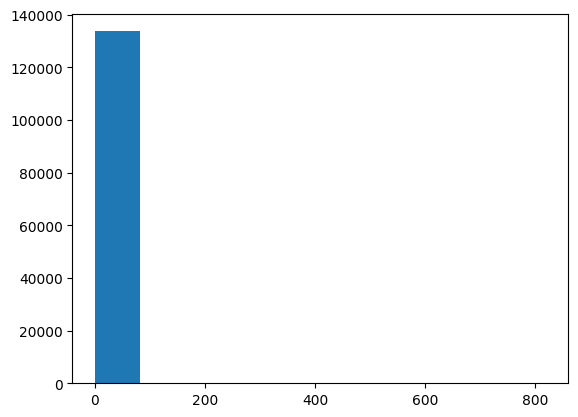

In [32]:
plt.hist(df['fare_amount'])
# plt.boxplot(df['fare_amount'])
plt.show()

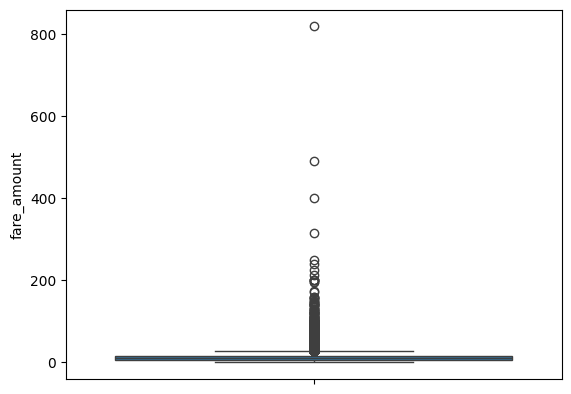

In [33]:
import seaborn as sns
sns.boxplot(df['fare_amount'])
plt.show()

Two methods to remove outliers:

Z-score
Interquartile Range (IQR) I prefer using IQR due to the non-normal distribution of the data.

In [34]:
for col in ['fare_amount','Duration','trip_distance_miles']:
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    IQR=q3-q1
    Lower_bound=q1-(1.5*IQR)
    upper_bound=q3+(1.5*IQR)
    df=df[(df[col]>=Lower_bound) & (df[col]<=upper_bound)]

In [35]:
df

,passenger_count,payment_type,fare_amount,trip_distance_miles,Duration
0,1,Card,9.0,1.949922,7.916667
1,1,Card,11.0,2.673965,11.100000
8,1,Card,5.5,0.520333,4.983333
10,2,Cash,4.0,0.459676,2.033333
11,1,Cash,8.0,1.365037,7.783333
...,...,...,...,...,...
143674,1,Card,5.5,0.431234,5.500000
143675,1,Card,10.0,0.919210,14.033333
143676,1,Card,8.5,0.980318,10.633333
143677,2,Card,7.5,1.023103,9.433333


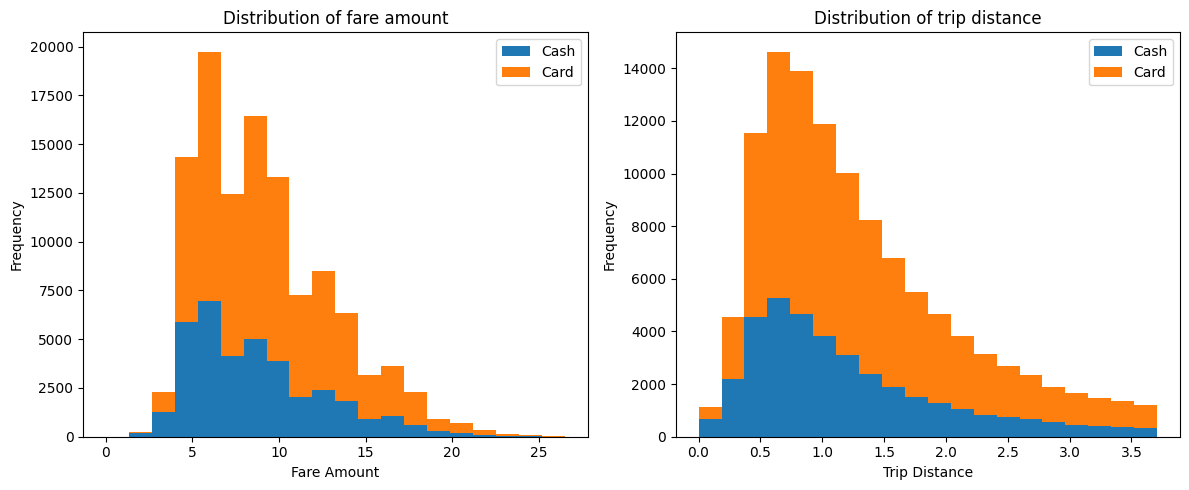

In [36]:
plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.title('Distribution of fare amount')
plt.hist([df[df['payment_type']=='Cash']['fare_amount'],
          df[df['payment_type']=='Card']['fare_amount']],
         stacked=True, label=['Cash', 'Card'], bins=20)
plt.legend()
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist([df[df['payment_type']=='Cash']['trip_distance_miles'],
          df[df['payment_type']=='Card']['trip_distance_miles']],
         stacked=True, label=['Cash', 'Card'], bins=20)
plt.title('Distribution of trip distance')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
df.groupby('payment_type').agg({'fare_amount':['mean','std'],'trip_distance_miles':['mean','std']})

fare_amount           trip_distance_miles          
                    mean       std                mean       std
payment_type                                                    
Card            9.407024  3.918118            1.346216  0.793822
Cash            8.624578  3.871918            1.192279  0.777932

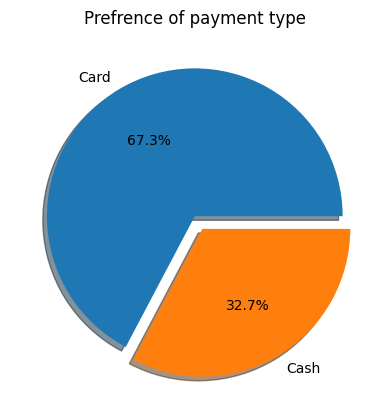

In [38]:
plt.title("Prefrence of payment type")
plt.pie(df['payment_type'].value_counts(normalize=True),labels=df['payment_type'].value_counts().index,
       autopct='%1.1f%%',explode=[0,0.1],shadow=True)
plt.show()

In [39]:
passenger_count=df.groupby(['payment_type','passenger_count'])[['passenger_count']].count()

In [40]:
passenger_count.rename(columns={"passenger_count": "count"}, inplace=True)

In [41]:
passenger_count.head()

count
payment_type passenger_count       
Card         1                54959
             2                10021
             3                 3026
             4                 1334
             5                 6255

In [42]:
passenger_count.reset_index(inplace=True)

In [43]:
passenger_count['Perc']=(passenger_count['count']/passenger_count['count'].sum())*100

In [44]:
passenger_count.sample(10)

,payment_type,passenger_count,count,Perc
7,Cash,3,1460,1.299164
1,Card,2,10021,8.917067
0,Card,1,54959,48.904609
9,Cash,5,2923,2.600997
5,Cash,1,26620,23.687489
3,Card,4,1334,1.187044
8,Cash,4,699,0.621997
2,Card,3,3026,2.692650
4,Card,5,6255,5.565937
6,Cash,2,5083,4.523047


In [45]:
tempDf=passenger_count.pivot(index=['payment_type'],columns=['passenger_count'],values=['Perc'])

In [46]:
tempDf

Perc                                        
passenger_count          1         2         3         4         5
payment_type                                                      
Card             48.904609  8.917067  2.692650  1.187044  5.565937
Cash             23.687489  4.523047  1.299164  0.621997  2.600997

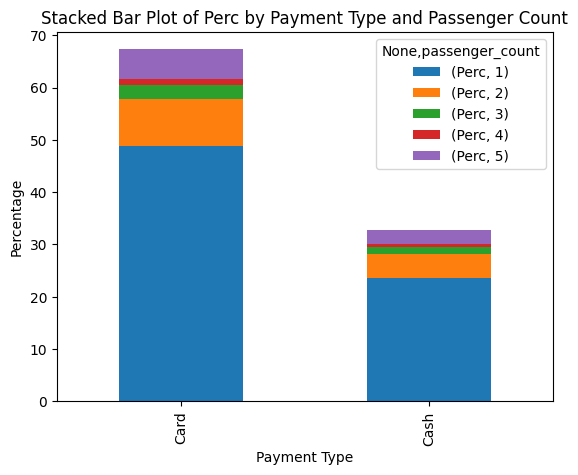

In [47]:
tempDf.plot(kind='bar', stacked=True)
plt.xlabel('Payment Type')
plt.ylabel('Percentage')
plt.title('Stacked Bar Plot of Perc by Payment Type and Passenger Count')
plt.show()

# **Hyphothesis Testing**

Null Hypothesis (H₀): The average fare amount is the same for customers who use credit cards and those who use cash.
Alternative Hypothesis (H₁): There is a significant difference in the average fare amount between customers who use credit cards and those who use cash.
Chechk Normality of data By QQ PLOT

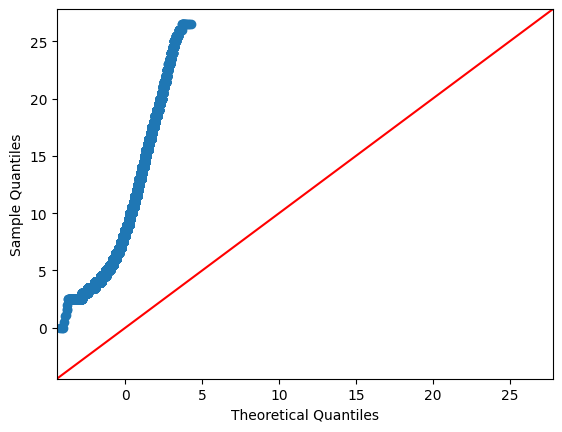

In [48]:
import statsmodels.api as sm
sm.qqplot(df['fare_amount'],line='45')
plt.show()

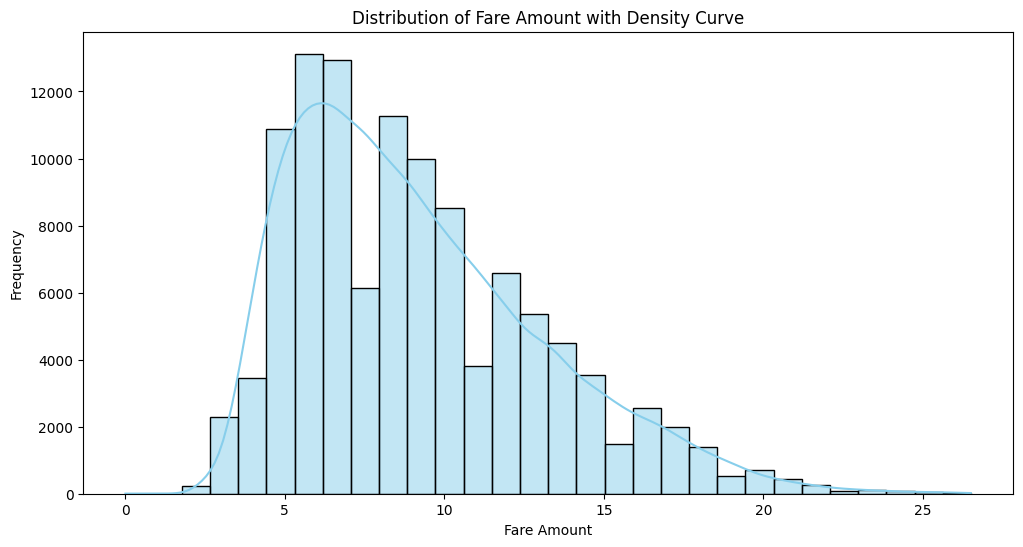

In [49]:
plt.figure(figsize=(12, 6))

sns.histplot(df['fare_amount'], kde=True, bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount with Density Curve')

plt.show()

In [50]:
card_sample=df[df['payment_type']=='Card']['fare_amount']
cash_sample=df[df['payment_type']=='Cash']['fare_amount']

In [51]:
cash_sample.sample(10)

,fare_amount
29180,4.5
17826,16.0
60564,15.0
70382,9.0
45727,7.5
15224,6.5
65524,5.0
31207,13.5
63681,15.0
52194,8.0


In [52]:
# independent T-test
from scipy import stats
t_stats, p_value = stats.ttest_ind(a=cash_sample, b=card_sample, equal_var=False)
print("T-statistics: {} and P-value: {}".format(t_stats, p_value))

T-statistics: -31.664022598480305 and P-value: 1.4385057784517092e-218


# **Data Visualization**

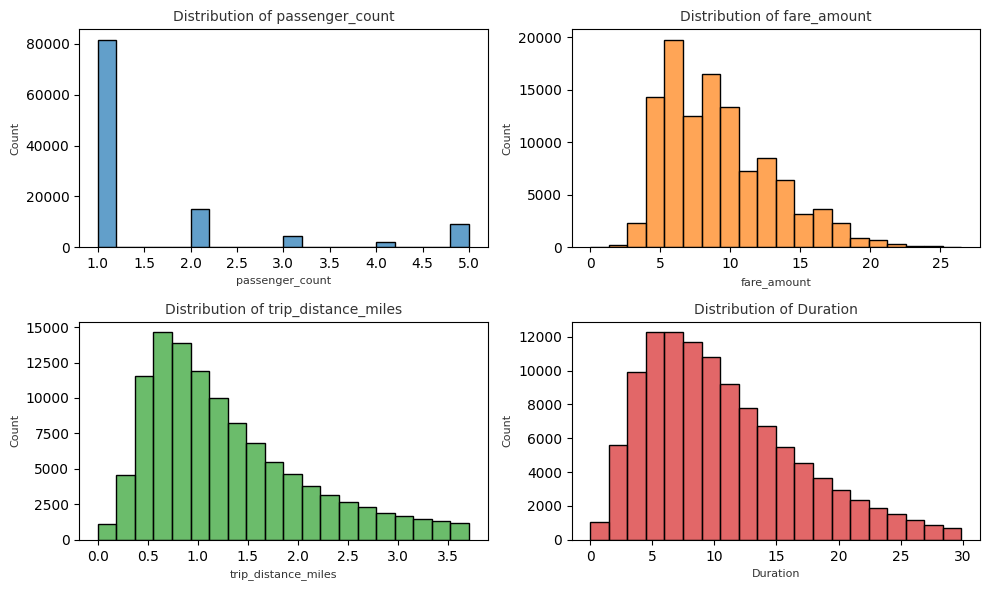

In [53]:
# define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

plt.figure(figsize=(10, 6)) # size figure

# loop over each column to draw
numerical_cols = df.select_dtypes(include=np.number).columns
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)  # (row, col, #plot)
    sns.histplot(df[col], bins=20, color=colors[i], alpha=0.7) # histogram
    plt.title(f'Distribution of {col}', fontsize=10, color='#333333')
    plt.xlabel(col, fontsize=8, color='#333333')
    plt.ylabel('Count', fontsize=8, color='#333333')

plt.tight_layout()
plt.show()

**Passenger Count**: Heavily skewed; most trips have 1 passenger, solo rides dominate.

**Trip Distance**: Right-skewed; most trips are short (0–2 miles), longer trips are rare.

**Fare Amount**: Right-skewed; most fares are  
5
–
 15, higher fares are uncommon.

**Duration**: Right-skewed; most trips last 0–15 minutes, longer durations are less frequent.

/tmp/ipython-input-2405955994.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='payment_type', data=df, palette=colors, alpha=0.8)
/tmp/ipython-input-2405955994.py:5: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x='payment_type', data=df, palette=colors, alpha=0.8)


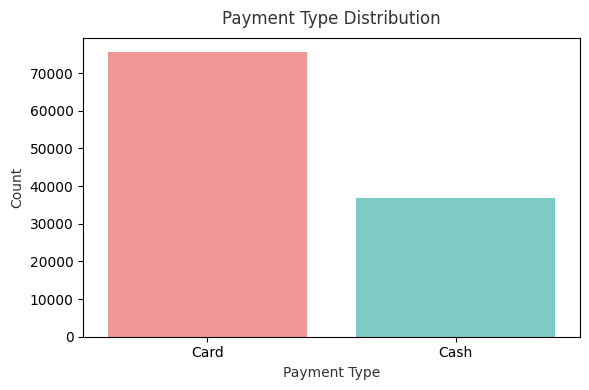

In [54]:
plt.figure(figsize=(6, 4)) # size figure

# define some color to use
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']  # Coral, Teal, Blue, Green, Light Yellow
sns.countplot(x='payment_type', data=df, palette=colors, alpha=0.8)

plt.title('Payment Type Distribution', fontsize=12, color='#333333', pad=10)
plt.xlabel('Payment Type', fontsize=10, color='#333333')
plt.ylabel('Count', fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

**Card Payments**: Dominant method, ~6 million trips.

**Cash Payments**: Much less common, ~1 million trips.

**Comparison**: Card payments are ~6x more frequent than cash, showing a preference for digital transactions

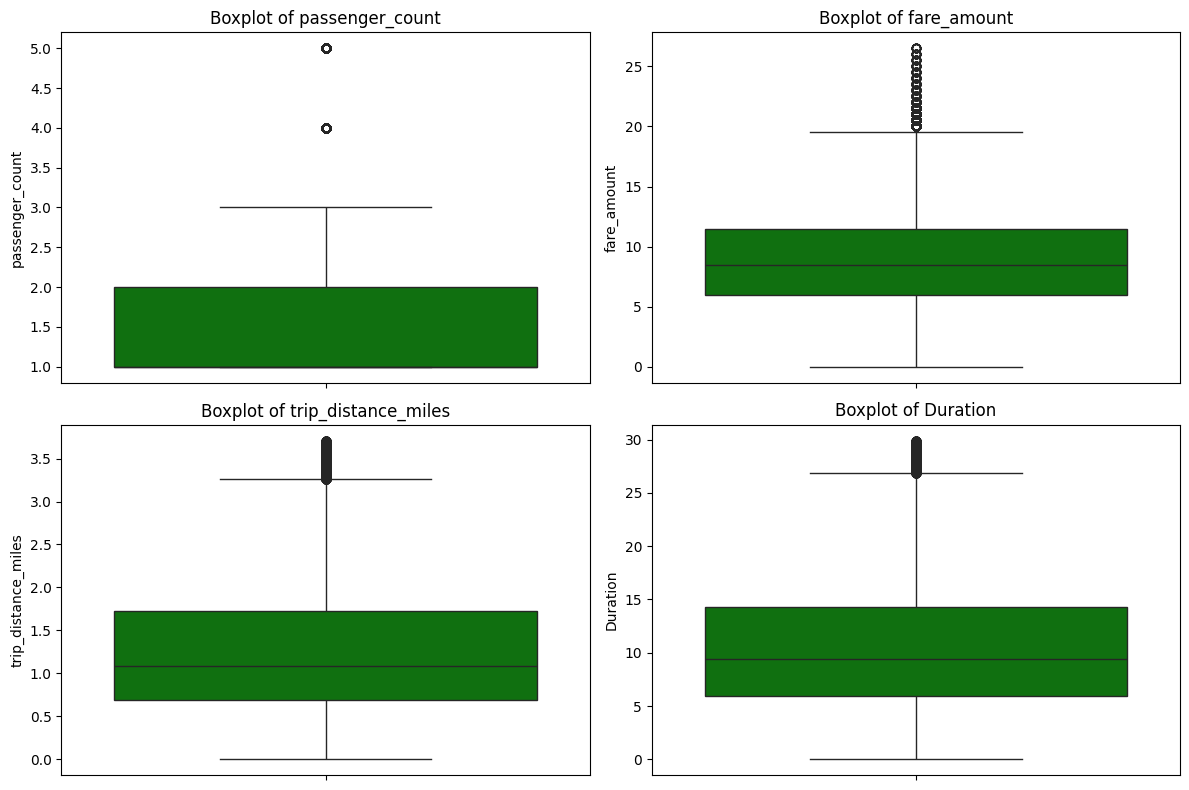

In [55]:
plt.figure(figsize=(12, 8)) # size figure
# loop over each columns
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(df[col], color='green')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

**Passenger Count**: IQR 1–2 passengers, outliers above 3, most trips have 1–2 passengers.

**Trip Distance**: IQR 0.5–2 miles, median ~1 mile, outliers beyond 4 miles, mostly short trips.

**Fare Amount**: IQR  
5
–
 15, median ~
10
,
o
u
t
l
i
e
r
s
a
b
o
v
e
 30, most fares are moderate.

**Duration**: IQR 5–15 minutes, median ~10 minutes, outliers past 25 minutes, mostly short trips.

/tmp/ipython-input-580746503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='payment_type', y='fare_amount', data=df, palette='Set2')


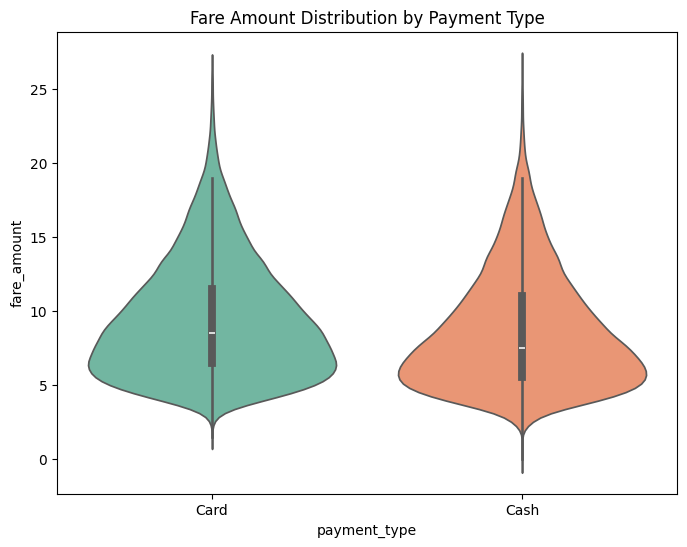

In [56]:
plt.figure(figsize=(8, 6)) # size figure
sns.violinplot(x='payment_type', y='fare_amount', data=df, palette='Set2')
plt.title('Fare Amount Distribution by Payment Type')
plt.show()

**Card Payments**: Right-skewed, peaks at  
10
–
 15, most fares below  
20
,
t
a
i
l
t
o
 40.

**Cash Payments**: Right-skewed, peaks at  
15
–
 20, similar spread, more variability in higher fares.

**Comparison**: Similar distributions, peaks at  
10
–
 20; cash has a higher median and more high fares.

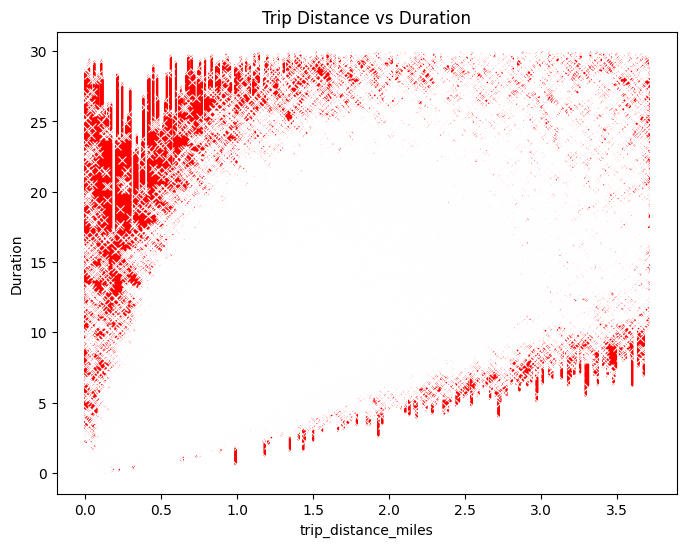

In [57]:
plt.figure(figsize=(8, 6)) # size figure
sns.lineplot(x='trip_distance_miles', y='Duration', data=df, marker='x', color='red')
plt.title('Trip Distance vs Duration')
plt.show()

**Relationship**: Positive relationship; duration increases with trip distance, forming a curved pattern.

**Data Spread**: Most points at 0–2 miles and 0–10 minutes, fewer at higher values, aligning with short trips.

**Trend **: Non-linear; duration rises faster for short distances, levels off for longer ones, possibly due to traffic or stops.

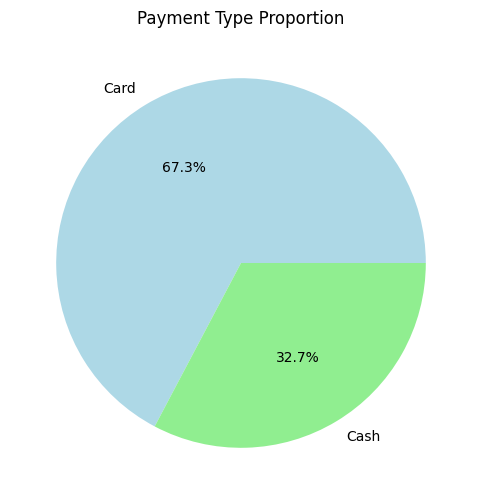

In [58]:
plt.figure(figsize=(6, 6)) # fig size
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Payment Type Proportion')
plt.ylabel('')
plt.show()

**Card Payments**: 82.9% of trips, dominant payment method.

**Cash Payments**: 17.1% of trips, minority payment method.

**Comparison**: Card payments are nearly 5x more common than cash, highlighting digital payment preference.

/tmp/ipython-input-3184600012.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['fare_amount'], shade=True, color='#FF6B6B')


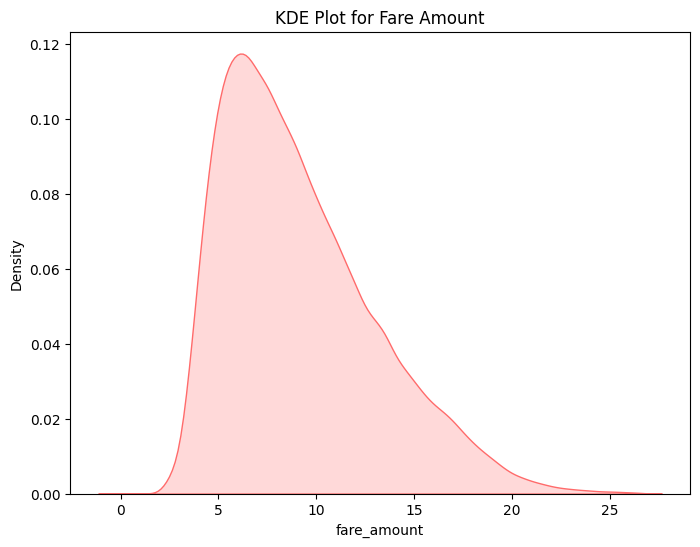

In [59]:
plt.figure(figsize=(8, 6)) # fig size
sns.kdeplot(df['fare_amount'], shade=True, color='#FF6B6B')
plt.title('KDE Plot for Fare Amount')
plt.show()

**Fare Amount Distribution**: Right-skewed, peaks at  
5
–
 10, most fares in this range.

**Density Spread**: Sharp drop after  
15
,
l
o
n
g
t
a
i
l
t
o
 40, higher fares are less common.

**Overall Trend**: Majority of fares are low, with few high-fare trips.

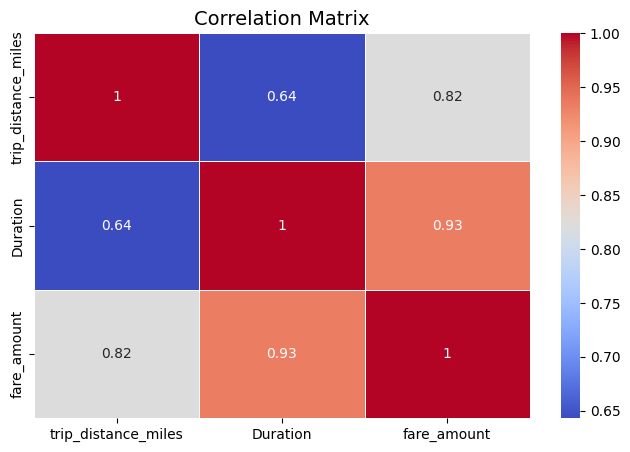

In [60]:
plt.figure(figsize=(8, 5))
sns.heatmap(df[['trip_distance_miles', 'Duration', 'fare_amount']].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

# **Summary EDA & Visualizations**

**Trip Characteristics**: Most taxi trips are short (0–2 miles, 5–15 minutes) with low fares (
5
–
 15) and 1–2 passengers, indicating urban, short-distance usage.

**Payment Preference**: Card payments dominate (82.9%, ~6M trips) over cash (17.1%, ~1M trips), showing a strong preference for digital transactions.

**Skewness and Outliers**: Numerical features (trip_distance, fare_amount, duration, passenger_count) are right-skewed with outliers, suggesting non-linear patterns and the need for careful preprocessing.

**Relationships**: trip_distance and duration have a non-linear positive relationship; fare_amount distributions are similar for card and cash, but cash payments have slightly higher medians and variability.

**Modeling Implications**: trip_distance and duration are likely strong predictors of fare_amount, while payment_type may have less impact due to its imbalance and similar fare distributions.

**Data Cleaning and Preprocessing**

**Outlier Treatment**: Cap extreme values to reduce their impact—e.g., set passenger_count above 5 to 5, trip_distance above 5 miles to 5, fare_amount above
40
t
o
40, and duration above 30 minutes to 30. Alternatively, apply a log transformation to these features to handle skewness.
Encode Categorical Variables: Convert payment_type (Card, Cash) into a binary format using one-hot encoding (e.g., payment_type_Cash as 1 for Cash, 0 for Card) to make it usable for modeling.

**Feature Engineering**: Create a fare_per_mile feature by dividing fare_amount by trip_distance (add a small constant to avoid division by zero). Bin duration into categories like short (0–10 mins), medium (10–20 mins), and long (>20 mins) to capture trip length patterns.

**Scaling Features**: Standardize numerical features after log transformation (e.g., log_trip_distance, log_fare_amount, log_duration) to ensure models sensitive to scale (like linear regression or SVM) perform well.

# **handle outliers**

In [61]:
numerical_cols = ['passenger_count', 'trip_distance_miles', 'fare_amount', 'Duration']
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25) # get q1
    Q3 = df[column].quantile(0.75) # get q3
    IQR = Q3 - Q1  # inter quartile range
    lower_bound = Q1 - 1.5 * IQR  # for upper outliers
    upper_bound = Q3 + 1.5 * IQR  # for lower outliers

    # clipping outliers -> if X < lower_bound set X = lower_bound & if X > upper_bound set X = upper_bound
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply Outliers On Data
for col in numerical_cols:
    df = cap_outliers_iqr(df, col)

# **Feature Engineering**

In [62]:
# Creat New Feature Name fare_per_mile
df['fare_per_mile'] = df['fare_amount'] / (df['trip_distance_miles'] + 0.01)

# Bin duration into categories: short (0–10 mins), medium (10–20 mins), long (>20 mins)
df['duration_bin'] = pd.cut(df['Duration'], bins=[0, 10, 20, float('inf')], labels=['short', 'medium', 'long'], include_lowest=True)

In [63]:
df['duration_bin'].value_counts()

,count
duration_bin,
short,60338
medium,41808
long,10234


# **Data Encoding**

In [64]:
from sklearn.preprocessing import LabelEncoder

label_encoder_duration = LabelEncoder()
df['duration_bin'] = label_encoder_duration.fit_transform(df['duration_bin'])

label_encoder_payment = LabelEncoder()
df['payment_type'] = label_encoder_payment.fit_transform(df['payment_type'])

In [65]:
df.head()

,passenger_count,payment_type,fare_amount,trip_distance_miles,Duration,fare_per_mile,duration_bin
0,1.0,0,9.0,1.949922,7.916667,4.592020,2
1,1.0,0,11.0,2.673965,11.100000,4.098414,1
8,1.0,0,5.5,0.520333,4.983333,10.370847,2
10,2.0,1,4.0,0.459676,2.033333,8.516515,2
11,1.0,1,8.0,1.365037,7.783333,5.818025,2


In [66]:
df.dtypes

,0
passenger_count,float64
payment_type,int64
fare_amount,float64
trip_distance_miles,float64
Duration,float64
fare_per_mile,float64
duration_bin,int64


In [67]:
df = df.astype({'passenger_count': 'int64'})

# **Data Spliting**

In [68]:
X = df.drop(columns = ['fare_amount'])
y = df['fare_amount']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

In [70]:
X_train.columns

Index(['passenger_count', 'payment_type', 'trip_distance_miles', 'Duration',
       'fare_per_mile', 'duration_bin'],
      dtype='object')

# **StandardScaler**

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['trip_distance_miles', 'Duration', 'fare_per_mile']] = scaler.fit_transform(X_train[['trip_distance_miles', 'Duration', 'fare_per_mile']])
X_test[['trip_distance_miles', 'Duration', 'fare_per_mile']] = scaler.transform(X_test[['trip_distance_miles', 'Duration', 'fare_per_mile']])

# **Models**

Evaluate Function

Linear Regression Model

Ridge Regression Model

Lasso Rigression Model

DecisionTree Regressor Model

RandomForest Regressor Model

# **Evaluate Function**

In [72]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, mse, rmse, r2

# **Linear Regression Model**

In [73]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

model_train_mae_lr, model_train_mse_lr, model_train_rmse_lr, model_train_r2_lr = evaluate_model(y_train, y_train_pred_lr)
model_test_mae_lr, model_test_mse_lr, model_test_rmse_lr, model_test_r2_lr = evaluate_model(y_test, y_test_pred_lr)

print('Linear Regression Model')
print()
print('Model Performance In Training Set')
print(f'- MAE : {model_train_mae_lr}')
print(f'- MSE : {model_train_mse_lr}')
print(f'- RMSE : {model_train_rmse_lr}')
print(f'- R2 : {model_train_r2_lr}')
print('-'* 40)
print('Model Performance In Test Set')
print(f'- MAE : {model_test_mae_lr}')
print(f'- MSE : {model_test_mse_lr}')
print(f'- RMSE : {model_test_rmse_lr}')
print(f'- R2 : {model_test_r2_lr}')
print('='* 40)
print()

Linear Regression Model

Model Performance In Training Set
- MAE : 0.43413248580236086
- MSE : 0.5332971701342648
- RMSE : 0.7302719836706492
- R2 : 0.9641091040698744
----------------------------------------
Model Performance In Test Set
- MAE : 0.43172473134576833
- MSE : 0.5189813002539816
- RMSE : 0.720403567629965
- R2 : 0.9646715979453923



# **Ridge Regression Model**

In [74]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

model_train_mae_r, model_train_mse_r, model_train_rmse_r, model_train_r2_r = evaluate_model(y_train, y_train_pred_ridge)
model_test_mae_r, model_test_mse_r, model_test_rmse_r, model_test_r2_r = evaluate_model(y_test, y_test_pred_ridge)

print('Ridge Model')
print()
print('Model Performance In Training Set')
print(f'- MAE : {model_train_mae_r}')
print(f'- MSE : {model_train_mse_r}')
print(f'- RMSE : {model_train_rmse_r}')
print(f'- R2 : {model_train_r2_r}')
print('-'* 40)
print('Model Performance In Test Set')
print(f'- MAE : {model_test_mae_r}')
print(f'- MSE : {model_test_mse_r}')
print(f'- RMSE : {model_test_rmse_r}')
print(f'- R2 : {model_test_r2_r}')
print('='* 40)
print()

Ridge Model

Model Performance In Training Set
- MAE : 0.4341309328850647
- MSE : 0.5332971751769627
- RMSE : 0.7302719871232655
- R2 : 0.9641091037305008
----------------------------------------
Model Performance In Test Set
- MAE : 0.43172284001166955
- MSE : 0.518979959320711
- RMSE : 0.7204026369473608
- R2 : 0.9646716892261951



# **Lasso Regression Model**

In [75]:
lasso = Lasso()
lasso.fit(X_train, y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

model_train_mae_l, model_train_mse_l, model_train_rmse_l, model_train_r2_l = evaluate_model(y_train, y_train_pred_lasso)
model_test_mae_l, model_test_mse_l, model_test_rmse_l, model_test_r2_l = evaluate_model(y_test, y_test_pred_lasso)

print('Lasso Model')
print()
print('Model Performance In Training Set')
print(f'- MAE : {model_train_mae_l}')
print(f'- MSE : {model_train_mse_l}')
print(f'- RMSE : {model_train_rmse_l}')
print(f'- R2 : {model_train_r2_l}')
print('-'* 40)
print('Model Performance In Test Set')
print(f'- MAE : {model_test_mae_l}')
print(f'- MSE : {model_test_mse_l}')
print(f'- RMSE : {model_test_rmse_l}')
print(f'- R2 : {model_test_r2_l}')
print('='* 40)
print()

Lasso Model

Model Performance In Training Set
- MAE : 0.9891404436040788
- MSE : 1.7948016978004353
- RMSE : 1.339702092929781
- R2 : 0.8792098579207717
----------------------------------------
Model Performance In Test Set
- MAE : 0.986337936687998
- MSE : 1.7594127883997357
- RMSE : 1.3264285839802066
- R2 : 0.8802322119541002



# **DecisionTree Regressor Model**

In [76]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

y_train_pred_dt = decision_tree.predict(X_train)
y_test_pred_dt = decision_tree.predict(X_test)

model_train_mae_dt, model_train_mse_dt, model_train_rmse_dt, model_train_r2_dt = evaluate_model(y_train, y_train_pred_dt)
model_test_mae_dt, model_test_mse_dt, model_test_rmse_dt, model_test_r2_dt = evaluate_model(y_test, y_test_pred_dt)

print('DecisionTreeRegressor Model')
print()
print('Model Performance In Training Set')
print(f'- MAE : {model_train_mae_dt}')
print(f'- MSE : {model_train_mse_dt}')
print(f'- RMSE : {model_train_rmse_dt}')
print(f'- R2 : {model_train_r2_dt}')
print('-'* 40)
print('Model Performance In Test Set')
print(f'- MAE : {model_test_mae_dt}')
print(f'- MSE : {model_test_mse_dt}')
print(f'- RMSE : {model_test_rmse_dt}')
print(f'- R2 : {model_test_r2_dt}')
print('='* 40)
print()

DecisionTreeRegressor Model

Model Performance In Training Set
- MAE : 0.0
- MSE : 0.0
- RMSE : 0.0
- R2 : 1.0
----------------------------------------
Model Performance In Test Set
- MAE : 0.04696787684641396
- MSE : 0.06712757163196298
- RMSE : 0.25908989102618996
- R2 : 0.9954304522370981



# **RandomForest Regressor Model**

In [77]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

model_train_mae_rf, model_train_mse_rf, model_train_rmse_rf, model_train_r2_rf = evaluate_model(y_train, y_train_pred_rf)
model_test_mae_rf, model_test_mse_rf, model_test_rmse_rf, model_test_r2_rf = evaluate_model(y_test, y_test_pred_rf)

print('RandomForestRegressor Model')
print()
print('Model Performance In Training Set')
print(f'- MAE : {model_train_mae_rf}')
print(f'- MSE : {model_train_mse_rf}')
print(f'- RMSE : {model_train_rmse_rf}')
print(f'- R2 : {model_train_r2_rf}')
print('-'* 40)
print('Model Performance In Test Set')
print(f'- MAE : {model_test_mae_rf}')
print(f'- MSE : {model_test_mse_rf}')
print(f'- RMSE : {model_test_rmse_rf}')
print(f'- R2 : {model_test_r2_rf}')
print('='* 40)
print()

RandomForestRegressor Model

Model Performance In Training Set
- MAE : 0.017673230334579168
- MSE : 0.007181784497352732
- RMSE : 0.08474540988957886
- R2 : 0.9995166659520767
----------------------------------------
Model Performance In Test Set
- MAE : 0.04643635878270158
- MSE : 0.054310033918846756
- RMSE : 0.23304513279372893
- R2 : 0.9963029752460341



In [78]:
from sklearn.ensemble import GradientBoostingRegressor

# ✅ Train Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predictions
y_train_pred_gbr = gbr.predict(X_train)
y_test_pred_gbr = gbr.predict(X_test)

# Evaluate
model_train_mae_gbr, model_train_mse_gbr, model_train_rmse_gbr, model_train_r2_gbr = evaluate_model(y_train, y_train_pred_gbr)
model_test_mae_gbr, model_test_mse_gbr, model_test_rmse_gbr, model_test_r2_gbr = evaluate_model(y_test, y_test_pred_gbr)

# ✅ Print results
print('Gradient Boosting Regression Model\n')

print('Model Performance on Training Set')
print(f'- MAE  : {model_train_mae_gbr:.4f}')
print(f'- MSE  : {model_train_mse_gbr:.4f}')
print(f'- RMSE : {model_train_rmse_gbr:.4f}')
print(f'- R2   : {model_train_r2_gbr:.4f}')
print('-'*40)

print('Model Performance on Test Set')
print(f'- MAE  : {model_test_mae_gbr:.4f}')
print(f'- MSE  : {model_test_mse_gbr:.4f}')
print(f'- RMSE : {model_test_rmse_gbr:.4f}')
print(f'- R2   : {model_test_r2_gbr:.4f}')
print('='*40)


Gradient Boosting Regression Model

Model Performance on Training Set
- MAE  : 0.3026
- MSE  : 0.2205
- RMSE : 0.4696
- R2   : 0.9852
----------------------------------------
Model Performance on Test Set
- MAE  : 0.3042
- MSE  : 0.2173
- RMSE : 0.4662
- R2   : 0.9852


In [81]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ✅ Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# ✅ Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_mae, train_mse, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

    results.append({
        "Model": name,
        "Train R2": train_r2, "Test R2": test_r2,
        "Train MAE": train_mae, "Test MAE": test_mae,
        "Train MSE": train_mse, "Test MSE": test_mse,
        "Train RMSE": train_rmse, "Test RMSE": test_rmse
    })

# ✅ Convert results into DataFrame for comparison
import pandas as pd
results_df = pd.DataFrame(results)

print("Model Comparison Results:\n")
print(results_df)

# ✅ Sort by Test R2 (best model on top)
results_df = results_df.sort_values(by="Test R2", ascending=False)
results_df


Model Comparison Results:

               Model  Train R2   Test R2  Train MAE  Test MAE  Train MSE  \
0  Linear Regression  0.964109  0.964672   0.434132  0.431725   0.533297   
1   Ridge Regression  0.964109  0.964672   0.434131  0.431723   0.533297   
2   Lasso Regression  0.964090  0.964660   0.433403  0.431017   0.533576   
3      Random Forest  0.999510  0.996389   0.017718  0.046350   0.007277   
4  Gradient Boosting  0.985159  0.985208   0.302561  0.304229   0.220526   

   Test MSE  Train RMSE  Test RMSE  
0  0.518981    0.730272   0.720404  
1  0.518980    0.730272   0.720403  
2  0.519156    0.730463   0.720525  
3  0.053045    0.085307   0.230315  
4  0.217304    0.469602   0.466159  


,Model,Train R2,Test R2,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
3,Random Forest,0.999510,0.996389,0.017718,0.046350,0.007277,0.053045,0.085307,0.230315
4,Gradient Boosting,0.985159,0.985208,0.302561,0.304229,0.220526,0.217304,0.469602,0.466159
1,Ridge Regression,0.964109,0.964672,0.434131,0.431723,0.533297,0.518980,0.730272,0.720403
0,Linear Regression,0.964109,0.964672,0.434132,0.431725,0.533297,0.518981,0.730272,0.720404
2,Lasso Regression,0.964090,0.964660,0.433403,0.431017,0.533576,0.519156,0.730463,0.720525


In [79]:
# User input
duration = float(input("Enter trip duration (in minutes): "))
trip_distance = float(input("Enter trip distance (in miles): "))

# Prepare data for prediction
# Note: We need to include all features that the model was trained on, even if the user doesn't input them directly.
# For this example, we will use placeholder values for 'passenger_count', 'payment_type', 'fare_per_mile', and 'duration_bin'
# as the model was trained on these features. In a real application, you would need to handle these inputs from the user or other sources.
# Also, the 'trip_distance' and 'duration' need to be scaled using the same scaler trained on the training data.

# Create a DataFrame with the correct columns and order based on X_train
input_data = pd.DataFrame([[1, 0, trip_distance, duration, 0.0, 0]],
                          columns=['passenger_count', 'payment_type', 'trip_distance_miles', 'Duration', 'fare_per_mile', 'duration_bin'])

# Scale the relevant numerical features using the scaler fitted on the training data
input_data[['trip_distance_miles', 'Duration', 'fare_per_mile']] = scaler.transform(input_data[['trip_distance_miles', 'Duration', 'fare_per_mile']])

# Predict the fare amount using the best performing model (RandomForestRegressor)
predicted_fare = random_forest.predict(input_data).item()

print(f"Estimated Fare Amount: ${predicted_fare:.2f}")

Enter trip duration (in minutes): 20
Enter trip distance (in miles): 12
Estimated Fare Amount: $13.56


In [80]:
# User input
passenger_count = int(input("Enter passenger count: "))
payment_type = int(input("Enter payment type (e.g., 0=Cash, 1=Card, etc.): "))
duration = float(input("Enter trip duration (in minutes): "))
trip_distance = float(input("Enter trip distance (in miles): "))

# Placeholder values for features not entered by user
fare_per_mile = 0.0       # default or placeholder
duration_bin = 0          # default or placeholder

# Prepare data for prediction
input_data = pd.DataFrame([[
    passenger_count,
    payment_type,
    trip_distance,
    duration,
    fare_per_mile,
    duration_bin
]],
    columns=['passenger_count', 'payment_type', 'trip_distance_miles', 'Duration', 'fare_per_mile', 'duration_bin']
)

# Scale numerical features
input_data[['trip_distance_miles', 'Duration', 'fare_per_mile']] = scaler.transform(
    input_data[['trip_distance_miles', 'Duration', 'fare_per_mile']]
)

# Predict fare
predicted_fare = random_forest.predict(input_data).item()

print(f"Estimated Fare Amount: ${predicted_fare:.2f}")


Enter passenger count: 11
Enter payment type (e.g., 0=Cash, 1=Card, etc.): 0
Enter trip duration (in minutes): 22
Enter trip distance (in miles): 2
Estimated Fare Amount: $8.76


# **Hyperparameter Tuning with RandomizedSearchCV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# ✅ Define model
gbr = GradientBoostingRegressor(random_state=42)

# ✅ Define hyperparameter grid (search space)
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.6, 0.8, 1.0]
}

# ✅ Randomized Search (faster than GridSearch)
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=30,              # number of parameter settings sampled
    scoring='r2',           # optimize for R²
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ✅ Fit search
random_search.fit(X_train, y_train)

# ✅ Best parameters & score
print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)

# ✅ Evaluate best model on test set
best_gbr = random_search.best_estimator_
y_test_pred = best_gbr.predict(X_test)

test_mae, test_mse, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

print("\nBest Gradient Boosting Model Performance on Test Set")
print(f"- MAE  : {test_mae}")
print(f"- MSE  : {test_mse}")
print(f"- RMSE : {test_rmse}")
print(f"- R²   : {test_r2}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


**GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

# ✅ Define smaller parameter grid (exhaustive search can be slow)
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)


# **Finalize Best Models**

In [ ]:
import pickle

# suppose GradientBoosting is best
best_model = best_gbr   # (or best_rf, best_lasso, etc.)

# ✅ Save model
with open("best_fare_prediction_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved as best_fare_prediction_model.pkl")

# **Load Model Later (for prediction)**

In [ ]:
# ✅ Load model
with open("best_fare_prediction_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# ✅ Use for prediction
sample_input = [[5.2, 15]]  # [trip_distance_km, trip_duration_min]
predicted_fare = loaded_model.predict(sample_input)

print("Predicted Fare:", predicted_fare[0])


# **Final Build a Streamlit UI**

In [ ]:
import streamlit as st
import pickle
import numpy as np

# -------------------------------
# Load trained model + preprocessing objects
# -------------------------------
with open("best_fare_prediction_model.pkl", "rb") as f:
    model = pickle.load(f)

# (Optional) If you also saved scaler/encoder
# with open("scaler.pkl", "rb") as f:
#     scaler = pickle.load(f)

# -------------------------------
# Streamlit UI
# -------------------------------
st.set_page_config(page_title="NYC Taxi Fare Prediction", page_icon="🚖", layout="centered")

st.title("🚖 NYC Taxi Fare Prediction App")
st.write("Enter trip details to predict the taxi fare.")

# Sidebar input
st.sidebar.header("Trip Details")

distance = st.sidebar.number_input("Trip Distance (miles)", min_value=0.1, max_value=100.0, step=0.1)
duration = st.sidebar.number_input("Trip Duration (minutes)", min_value=1, max_value=500, step=1)
passenger_count = st.sidebar.slider("Passenger Count", 1, 6, 1)
pickup_hour = st.sidebar.slider("Pickup Hour (0–23)", 0, 23, 12)
pickup_day = st.sidebar.selectbox("Pickup Day", ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

if st.sidebar.button("Predict Fare"):
    # Convert categorical to numeric (example encoding)
    day_map = {"Monday":0,"Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6}
    pickup_day_num = day_map[pickup_day]

    # Prepare features (adjust order based on your training features)
    input_features = np.array([[distance, duration, passenger_count, pickup_hour, pickup_day_num]])

    # If you used scaling
    # input_features = scaler.transform(input_features)

    predicted_fare = model.predict(input_features)[0]

    st.success(f"💰 Estimated Fare: **${predicted_fare:.2f}**")
